In [56]:


import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import pandas as pd
from geopy.distance import great_circle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Dropout, Dense, LSTM, Embedding, Conv1D, MaxPool1D, Flatten
from keras import regularizers
from keras.optimizers import Adam
from keras.models import Sequential
import keras
from sklearn.decomposition import PCA




cal = pd.read_csv('H:\kaggle projects\HACKFEST\calendar_summary.csv')
lis=pd.read_csv('H:\kaggle projects\HACKFEST\listings_summary.csv')
# rev=pd.read_csv('H:\kaggle projects\HACKFEST\reviews_summary.csv')


lis.head()








,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [57]:

columns_to_keep = ['id',  'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']



df = lis[columns_to_keep].set_index('id')
df.cleaning_fee.fillna('$0.00', inplace=True)
df.security_deposit.fillna('$0.00', inplace=True)
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

df.drop(df[ (df.price > 400) | (df.price == 0) ].index, axis=0, inplace=True)
df.dropna( inplace=True)
df.host_has_profile_pic.fillna(value='f', inplace=True)


def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)
df['size'] = df['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df['size'] = df['size'].str.replace("\D", "")
df['size'] = df['size'].astype(float)
df.drop(['description'], axis=1, inplace=True)


df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')
df['Wifi'] = df['amenities'].str.contains('Wifi')
df['Kitchen'] = df['amenities'].str.contains('Kitchen')
#df['Heating'] = df['amenities'].str.contains('Heating')
df['Essentials'] = df['amenities'].str.contains('Essentials')
df['Hair_dryer'] = df['amenities'].str.contains('Hair dryer')
#df['Cable TV'] = df['amenities'].str.contains('Cable TV')
df['Bed_linens'] = df['amenities'].str.contains('Bed linens')
#df['Shampoo'] = df['amenities'].str.contains('Shampoo')
df['Internet'] = df['amenities'].str.contains('Internet')
df['Elevator'] = df['amenities'].str.contains('Elevator')
df['Refrigerator'] = df['amenities'].str.contains('Refrigerator')
df['Dishes_and_silverware'] = df['amenities'].str.contains('Dishes and silverware')
#df['Hot_water'] = df['amenities'].str.contains('Hot water')
df['Stove'] = df['amenities'].str.contains('Stove')
#df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')


In [58]:
one_hot = pd.get_dummies(df['host_has_profile_pic'], prefix = 'host_has_profile_pic')
df.drop("host_has_profile_pic",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['neighbourhood_group_cleansed'], prefix = 'neighbourhood_group_cleansed')
df.drop("neighbourhood_group_cleansed",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['property_type'], prefix = 'property_type')
df.drop("property_type",inplace = True, axis = 1)
df = df.join(one_hot)


one_hot = pd.get_dummies(df['room_type'], prefix = 'room_type')
df.drop("room_type",inplace = True, axis = 1)
df = df.join(one_hot)


one_hot = pd.get_dummies(df['bed_type'], prefix = 'bed_type')
df.drop("bed_type",inplace = True, axis = 1)
df = df.join(one_hot)


one_hot = pd.get_dummies(df['instant_bookable'], prefix = 'instant_bookable')
df.drop("instant_bookable",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['is_business_travel_ready'], prefix = 'is_business_travel_ready')
df.drop("is_business_travel_ready",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['cancellation_policy'], prefix = 'cancellation_policy')
df.drop("cancellation_policy",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Laptop_friendly_workspace'], prefix = 'Laptop_friendly_workspace')
df.drop("Laptop_friendly_workspace",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['TV'], prefix = 'TV')
df.drop("TV",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Family_kid_friendly'], prefix = 'Family_kid_friendly')
df.drop("Family_kid_friendly",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Host_greets_you'], prefix = 'Host_greets_you')
df.drop("Host_greets_you",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Smoking_allowed'], prefix = 'Smoking_allowed')
df.drop("Smoking_allowed",inplace = True, axis = 1)
df = df.join(one_hot)


one_hot = pd.get_dummies(df['Wifi'], prefix = 'Wifi')
df.drop("Wifi",inplace = True, axis = 1)
df = df.join(one_hot)


one_hot = pd.get_dummies(df['Kitchen'], prefix = 'Kitchen')
df.drop("Kitchen",inplace = True, axis = 1)
df = df.join(one_hot)


# one_hot = pd.get_dummies(df['Heating'], prefix = 'Heating')
# df.drop("Heating",inplace = True, axis = 1)
# df = df.join(one_hot)


one_hot = pd.get_dummies(df['Essentials'], prefix = 'Essentials')
df.drop("Essentials",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Hair_dryer'], prefix = 'Hair_dryer')
df.drop("Hair_dryer",inplace = True, axis = 1)
df = df.join(one_hot)

# one_hot = pd.get_dummies(df['Cable TV'], prefix = 'Cable_TV')
# df.drop("Cable TV",inplace = True, axis = 1)
# df = df.join(one_hot)

one_hot = pd.get_dummies(df['Bed_linens'], prefix = 'Bed_linens')
df.drop("Bed_linens",inplace = True, axis = 1)
df = df.join(one_hot)

# one_hot = pd.get_dummies(df['Shampoo'], prefix = 'Shampoo')
# df.drop("Shampoo",inplace = True, axis = 1)
# df = df.join(one_hot)


one_hot = pd.get_dummies(df['Internet'], prefix = 'Internet')
df.drop("Internet",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Elevator'], prefix = 'Elevator')
df.drop("Elevator",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Refrigerator'], prefix = 'Refrigerator')
df.drop("Refrigerator",inplace = True, axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['Dishes_and_silverware'], prefix = 'Dishes_and_silverware')
df.drop("Dishes_and_silverware",inplace = True, axis = 1)
df = df.join(one_hot)

# one_hot = pd.get_dummies(df['Hot_water'], prefix = 'Hot_water')
# df.drop("Hot_water",inplace = True, axis = 1)
# df = df.join(one_hot)

one_hot = pd.get_dummies(df['Stove'], prefix = 'Stove')
df.drop("Stove",inplace = True, axis = 1)
df = df.join(one_hot)


In [59]:
df.drop(['latitude', 'longitude', 'amenities', 'size'], axis=1, inplace=True)
y = df['price'].values
X = df
X.drop(['price'],axis = 1, inplace=True)

In [60]:
X

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,host_has_profile_pic_f,...,Internet_False,Internet_True,Elevator_False,Elevator_True,Refrigerator_False,Refrigerator_True,Dishes_and_silverware_False,Dishes_and_silverware_True,Stove_False,Stove_True
id,,,,,,,,,,,,,,,,,,,,,
2015,3,1.0,1.0,30.0,200.0,28.0,1,4,3.533182,0,...,1,0,1,0,0,1,0,1,0,1
2695,2,1.0,1.0,0.0,0.0,0.0,1,2,5.085573,0,...,1,0,0,1,1,0,1,0,1,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,62,3.695677,0,...,0,1,1,0,1,0,1,0,1,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,5,3.755285,0,...,0,1,1,0,1,0,0,1,1,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,2,4.550423,0,...,1,0,1,0,1,0,1,0,1,0
9991,7,2.5,4.0,80.0,400.0,10.0,5,6,3.458693,0,...,0,1,0,1,0,1,0,1,0,1
14325,2,1.0,0.0,0.0,500.0,0.0,1,90,5.012297,0,...,0,1,1,0,1,0,1,0,1,0
16401,2,1.0,1.0,0.0,0.0,13.0,1,30,3.733805,0,...,0,1,1,0,1,0,1,0,1,0
16644,5,1.0,1.0,50.0,500.0,20.0,2,60,2.105810,0,...,1,0,1,0,1,0,1,0,1,0


In [62]:

sc = MinMaxScaler()

X = sc.fit_transform(X)
# sc = MinMaxScaler()
sc_y = sc.fit(y.reshape(-1,1))
y = sc.transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=21)





In [63]:
X

array([[0.13333333, 0.11764706, 0.11111111, ..., 1.        , 0.        ,
        1.        ],
       [0.06666667, 0.11764706, 0.11111111, ..., 0.        , 1.        ,
        0.        ],
       [0.2       , 0.11764706, 0.11111111, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.06666667, 0.11764706, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06666667, 0.11764706, 0.11111111, ..., 0.        , 1.        ,
        0.        ],
       [0.06666667, 0.11764706, 0.11111111, ..., 0.        , 1.        ,
        0.        ]])

In [64]:
y

array([[0.14786967],
       [0.04010025],
       [0.22305764],
       ...,
       [0.21052632],
       [0.24561404],
       [0.11027569]])

In [65]:
pca = PCA(n_components = 64)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [66]:

def ann_model():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim=64))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=256))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=256))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=256))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=128))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=128))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=128))
    model.add(Dropout(0.1))
    model.add(Dense(activation="relu", units=64))
    model.add(Dropout(0.3))
    model.add(Dense(activation="sigmoid", units=1))
    model.compile(optimizer = 'Adam',loss = 'mse', metrics = [ 'mae'])
    return model

model = ann_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
__________

In [68]:
try:
    tbCallbacks = keras.callbacks.TensorBoard(log_dir='./logs_2', histogram_freq=0, batch_size=128, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    model.fit(X_train, y_train, callbacks=[tbCallbacks],epochs=100,batch_size=32)
except KeyboardInterrupt:
    print("\nInterrupting")


Epoch 1/100
19947/19947 [==============================] - 5s 261us/step - loss: 0.0066 - mean_absolute_error: 0.0539
Epoch 2/100
19947/19947 [==============================] - 5s 261us/step - loss: 0.0061 - mean_absolute_error: 0.0520
Epoch 3/100
19947/19947 [==============================] - 5s 271us/step - loss: 0.0059 - mean_absolute_error: 0.0511
Epoch 4/100
19947/19947 [==============================] - 5s 256us/step - loss: 0.0057 - mean_absolute_error: 0.0503
Epoch 5/100
19947/19947 [==============================] - 5s 255us/step - loss: 0.0054 - mean_absolute_error: 0.0490
Epoch 6/100
19947/19947 [==============================] - 6s 280us/step - loss: 0.0053 - mean_absolute_error: 0.0487
Epoch 7/100
19947/19947 [==============================] - 5s 262us/step - loss: 0.0052 - mean_absolute_error: 0.0482
Epoch 8/100
19947/19947 [==============================] - 5s 260us/step - loss: 0.0050 - mean_absolute_error: 0.0474
Epoch 9/100
19947/19947 [==============================]

In [74]:

#MSE  DURING TRAINING : 0.0028 and mae of 0.0369
#MSE ON TEST SET : 0.00047

y_pred = model.predict(X_test)


y_pred = sc_y.inverse_transform(y_pred)
y_t = sc_y.inverse_transform(y_test)
# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
from sklearn.metrics import mean_squared_error, r2_score
print("R2 score : %.2f" % r2_score(y_t,y_pred))

R2 score : 0.53


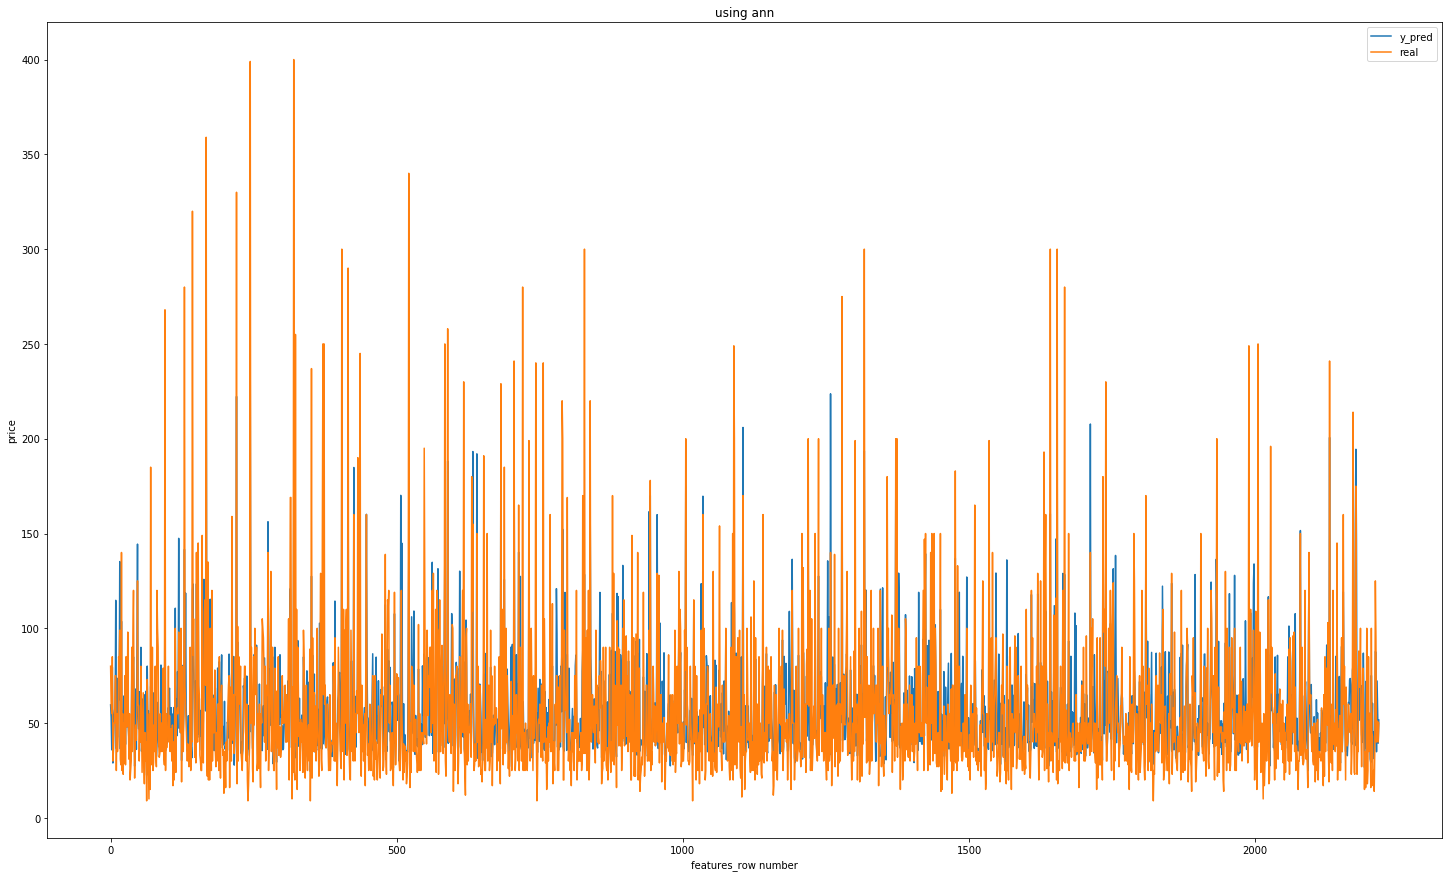

In [71]:



plt.figure(figsize=(25,15))
plt.plot(y_pred, label ='y_pred')
plt.plot(y_t, label = 'real')
plt.xlabel('features_row number')
plt.ylabel('price')
plt.title("using ann")
plt.legend()

<function mean_pred at 0x000001F6CAB1C158>
